## FFT 1D with a regular holo phase patttern

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-14
- last update : 2025-01-14 
- last update : 2024-01-15 : Save formula
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Function tools

In [3]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    new_angle = np.where(new_angle < 0,np.abs(new_angle) + 2 * (np.pi - np.abs(new_angle)),new_angle)
    return new_angle

In [4]:
convert_angle_to_0_2pi_interval(-np.pi/4)

array(5.49778714)

In [5]:
def convert_angle_to_mpi_ppi_interval(angle):
    new_angle = convert_angle_to_0_2pi_interval(angle)
    new_angle = np.where(new_angle > np.pi, new_angle - 2*np.pi,new_angle)

    return new_angle

### Auxtel Configuration

In [6]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [7]:
beam_radius_mm

5.0

### Diffraction Pattern

In [8]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin
a = 1/Neff

### Hologram recording

In [9]:
lambda_R = 0.639e-3 #mm
dR = 20.0
DR = dR/lambda_R/Neff

## Optical depth pattern function

The interference of the two point sources $A,B$ on the hologram emulsion is described
by the following formula
$$
U_{tot} = U_a + U_b = a\frac{e^{ikr_{AM}}}{r_{AM}} + b\frac{e^{ikr_{BM}}}{r_{BM}}
$$
where $a,b$ are the complex amplitudes of the sources at their emission location and the exponential terms $\frac{e^{ikr}}{r}$ describe the outgoing spherical waves.

- If we approximate $\frac{1}{r_{AM}} \simeq \frac{1}{r_{BM}} \simeq \frac{1}{D_R}$,
- We redefine (a,b) by a relative phase shift between the souces $\Delta \psi$ and a relative positive amplitudes (by definition as the phase shift account for negative)
  $\cos \beta, \sin \beta$ such $0 \le \beta \le \frac{\pi}{4}$:
$$
\begin{array}{ccc}
a & = &a_0 \cos \beta e^{-i \frac{\Delta \psi}{2}} \\
b & = & a_0  \sin\beta  e^{i \frac{\Delta \psi}{2}}
\end{array}
$$

Redfining the coordinate in the recording plane $w$ by $x$:

$$
\begin{array}{ccc}
D_{AM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x \\
D_{BM}^2 & = & D_R^2 + \left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x 
\end{array}
$$

If we approximate $D_R \gg d_R,l,x$:

$$
\begin{array}{ccc}
D_{AM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 + d_R\cdot x }{2D_R}\\
D_{BM} & = & D_R + \frac{\left( \frac{d_R}{2}\right)^2 + l^2 - d_R \cdot x }{2D_R}
\end{array}
$$


### Pattern recorded on emulsion

$$
I = \| U_{tot} \|^2 \propto 1 +  \sin 2\beta \cdot \cos \left( k\frac{d_R\cdot x}{D_R}  -  \Delta \psi \right) =  1 +  \sin 2\beta \cdot \cos \left( 2\pi \frac{d_R\cdot x}{\lambda_F D_R}  -  \Delta \psi \right) 
$$

The periodicity is:

$$
\Delta x = \frac{\lambda_R D_R}{d_R}
$$

and the interference contrast $0 <C< 1$ is :

$ C = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \sin 2\beta$

- Note if the two sources have the same amplitudes within a phase shift the contrast is maximal.

In [10]:
delta_x = (DR*lambda_R/dR)
print(f"the periodicity of the lines is {delta_x:.4f} mm and Neff = {1/delta_x}")

the periodicity of the lines is 0.0067 mm and Neff = 150.0


## Transmission functions

In [11]:
def set_beam_aperture(x,radius = beam_radius_mm):
    """
    """
    a = np.where(np.logical_or(x<-radius,x>radius),0.,1.)
    return a

In [12]:
def set_holo_pattern_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=1):
    """
    Generate a square pattern of transmission.
    x in mm
    xshift : between -1,1
    contrast : 
    """
    a = 1/opticalelement_nblines_permm
    x = (x + xshift*a/2)/a
    y = (1+contrast*np.cos(2*np.pi*x))/2.
    return y

(0.0, 1.0)

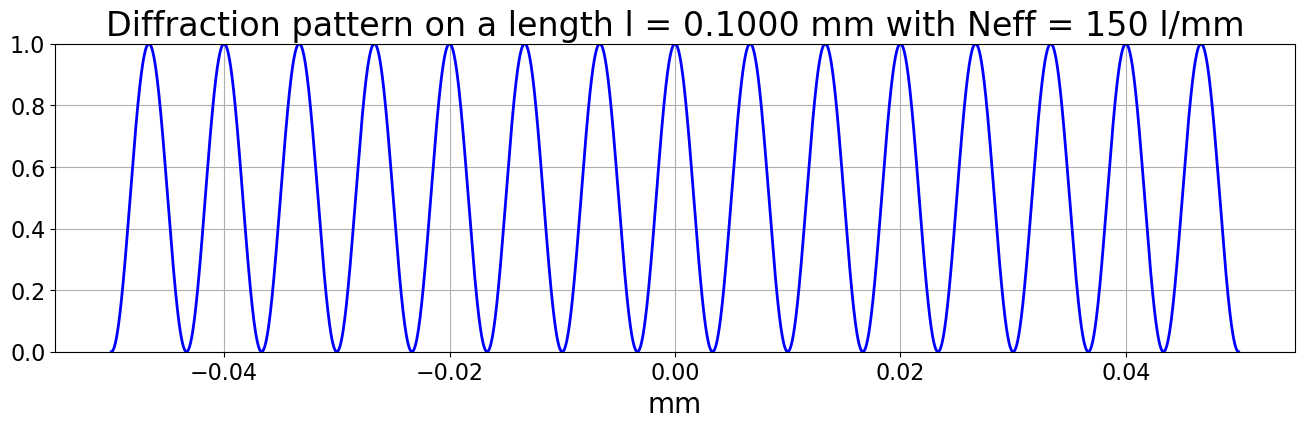

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-.05,0.05,5000)
y = set_holo_pattern_debug(x,xshift=0)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")
ax.set_ylim(0.,1.)

In [68]:
def set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=1):
    """
    Generate a square phase pattern of transmission including the pupil function.
    x in mm
    xshift : between -1,1
    """
    a = 1/opticalelement_nblines_permm
    #x = x + xshift*a/2
    
    #r = np.exp(1j*np.pi*np.rint(x/a-0.25 - np.floor(x/a-0.25))-0.5)
    r = np.exp(1j*np.pi* set_holo_pattern_debug(x,opticalelement_nblines_permm=Neff,xshift=xshift,contrast=contrast))
    rcut = np.where(np.logical_or(x<-beam_radius_mm,x>beam_radius_mm),0,r)
    return rcut

### Do the control

In [71]:
x = np.linspace(-.05,0.05,100000)
yc = set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0,contrast=1)

Text(0.5, 0, ' x (mm)')

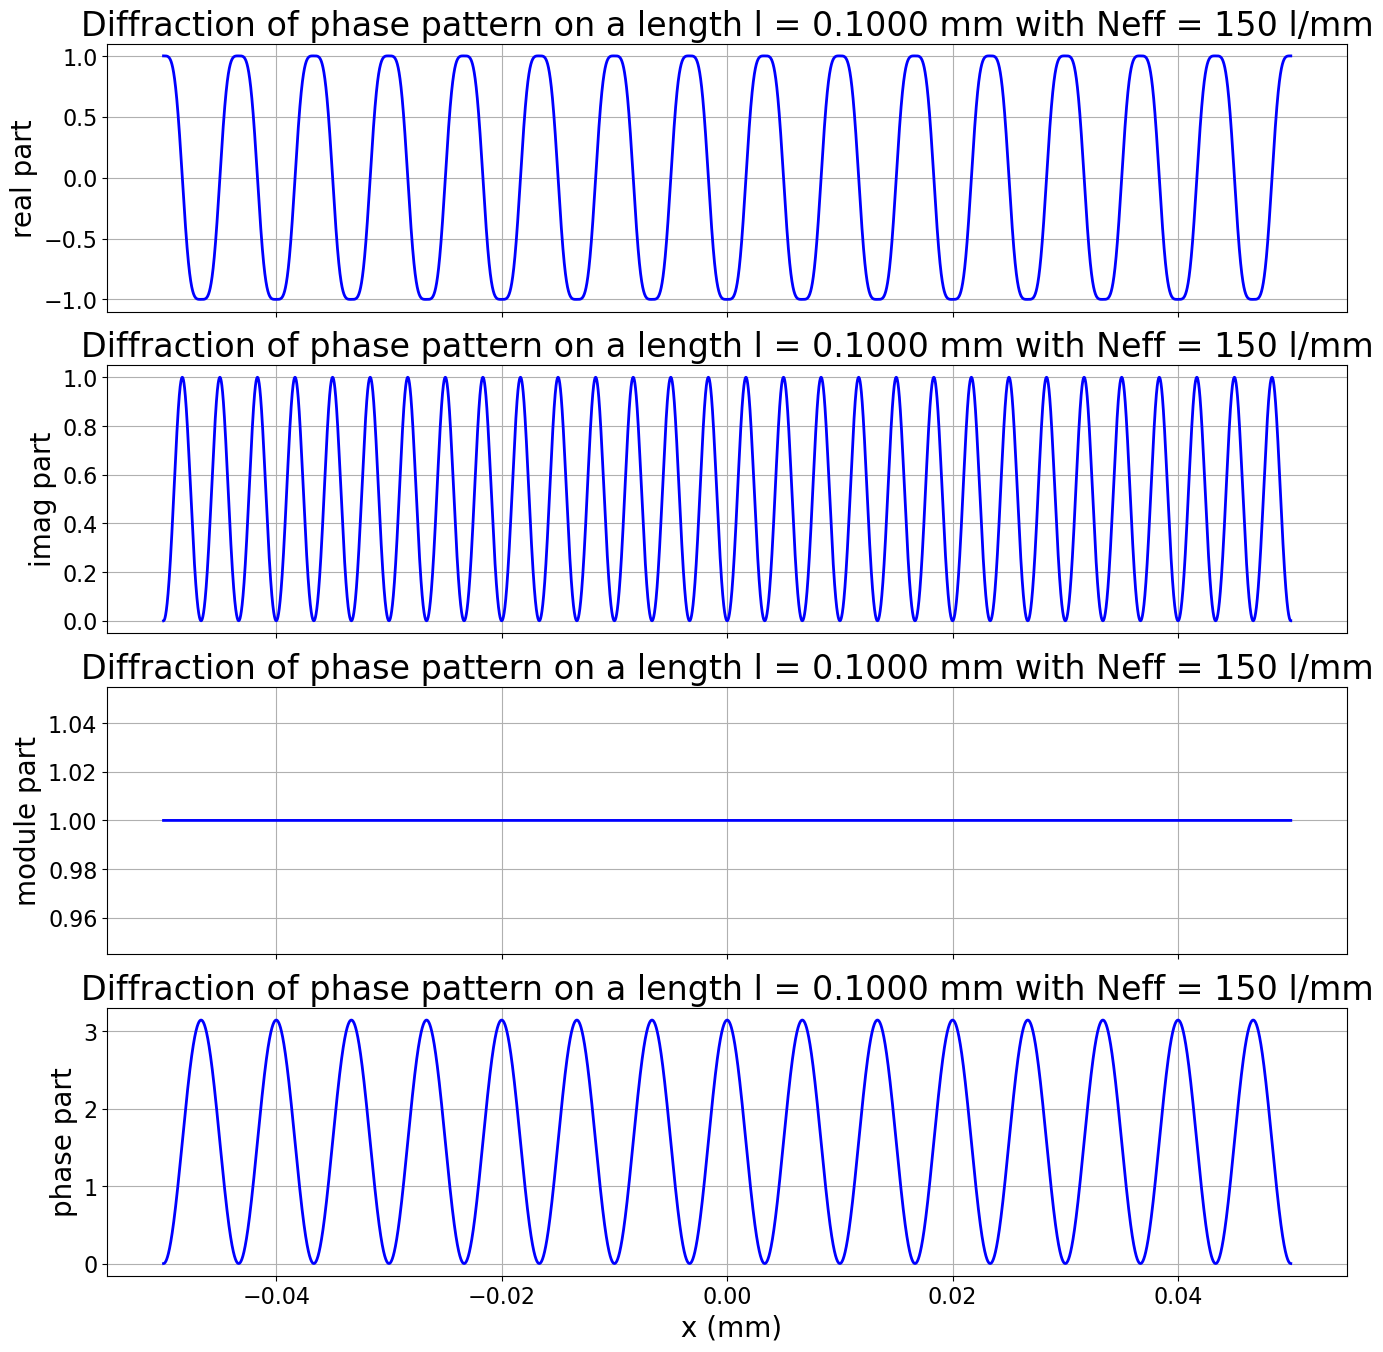

In [72]:
# check the generated pattern
fig,axs = plt.subplots(4,1,figsize=(16,16),sharex=True)
ax1,ax2,ax3,ax4 = axs.flatten()

ax1.plot(x,yc.real,'b-',label="real part")
ax1.grid()
ax1.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax1.set_ylabel("real part")

ax2.plot(x,yc.imag,'b-',label="imag part")
ax2.grid()
ax2.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax2.set_ylabel("imag part")

ax3.plot(x,np.abs(yc),'b-',label="module part")
ax3.grid()
ax3.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax3.set_ylabel("module part")


ax4.plot(x,np.angle(yc),'b-',label="phase part")
ax4.grid()
ax4.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax4.set_ylabel("phase part")

ax4.set_xlabel(" x (mm)")

### Parameters of the FFT

In [17]:
#Nb = 10001 ## Too small for sampling
Nb = 40001 ## 
padding_factor = 1.5

In [18]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [19]:
print(f"Sampling distance dxe = {dxe} mm ")
print(f"Sampling frequency fe = {fe:.3f} mm -1")
print(f"Max signal requency fmax = {fmax:.3f} mm -1 before aliasing")
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Sampling distance dxe = 0.000375 mm 
Sampling frequency fe = 2666.667 mm -1
Max signal requency fmax = 1333.333 mm -1 before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


## Compute inputs for the FFT

### Pattern shift

In [20]:
XSHIFT = 0

### Input for the aperture

In [21]:
ap = set_beam_aperture(xe)

### Input for the pattern

In [22]:
ye = set_holo_pattern_debug(xe,xshift=XSHIFT)
# set padding on the borders
r = np.where(np.logical_or(xe<-beam_radius_mm,xe>beam_radius_mm),0,ye)

## Plots the patterns

### Aperture pattern

Text(0.5, 0, 'mm')

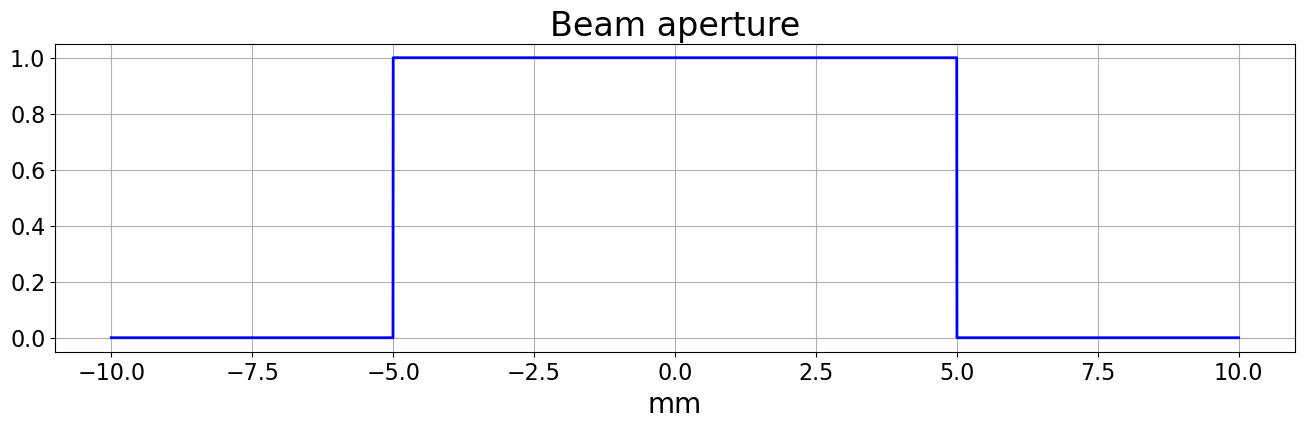

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-10.,10.,5000)
y = set_beam_aperture(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Beam aperture")
ax.set_xlabel("mm")

## Compute the FFT

### FFT for the beam with the aperture only

In [24]:
spa = np.fft.fft(ap)
# the frequency in units of mm^-1

# do a deep copy
freqa = np.array(np.fft.fftfreq(ap.shape[-1], d=dxe))
reala = np.array(spa.real)
imaga = np.array(spa.imag)
modulea = np.array(np.abs(spa))
phasea = np.array(np.angle(spa))

In [25]:
freqa = np.fft.fftshift(freqa)
reala = np.fft.fftshift(reala)
imaga = np.fft.fftshift(imaga)
modulea = np.fft.fftshift(modulea)
phasea = np.fft.fftshift(phasea)
N = len(freqa)

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

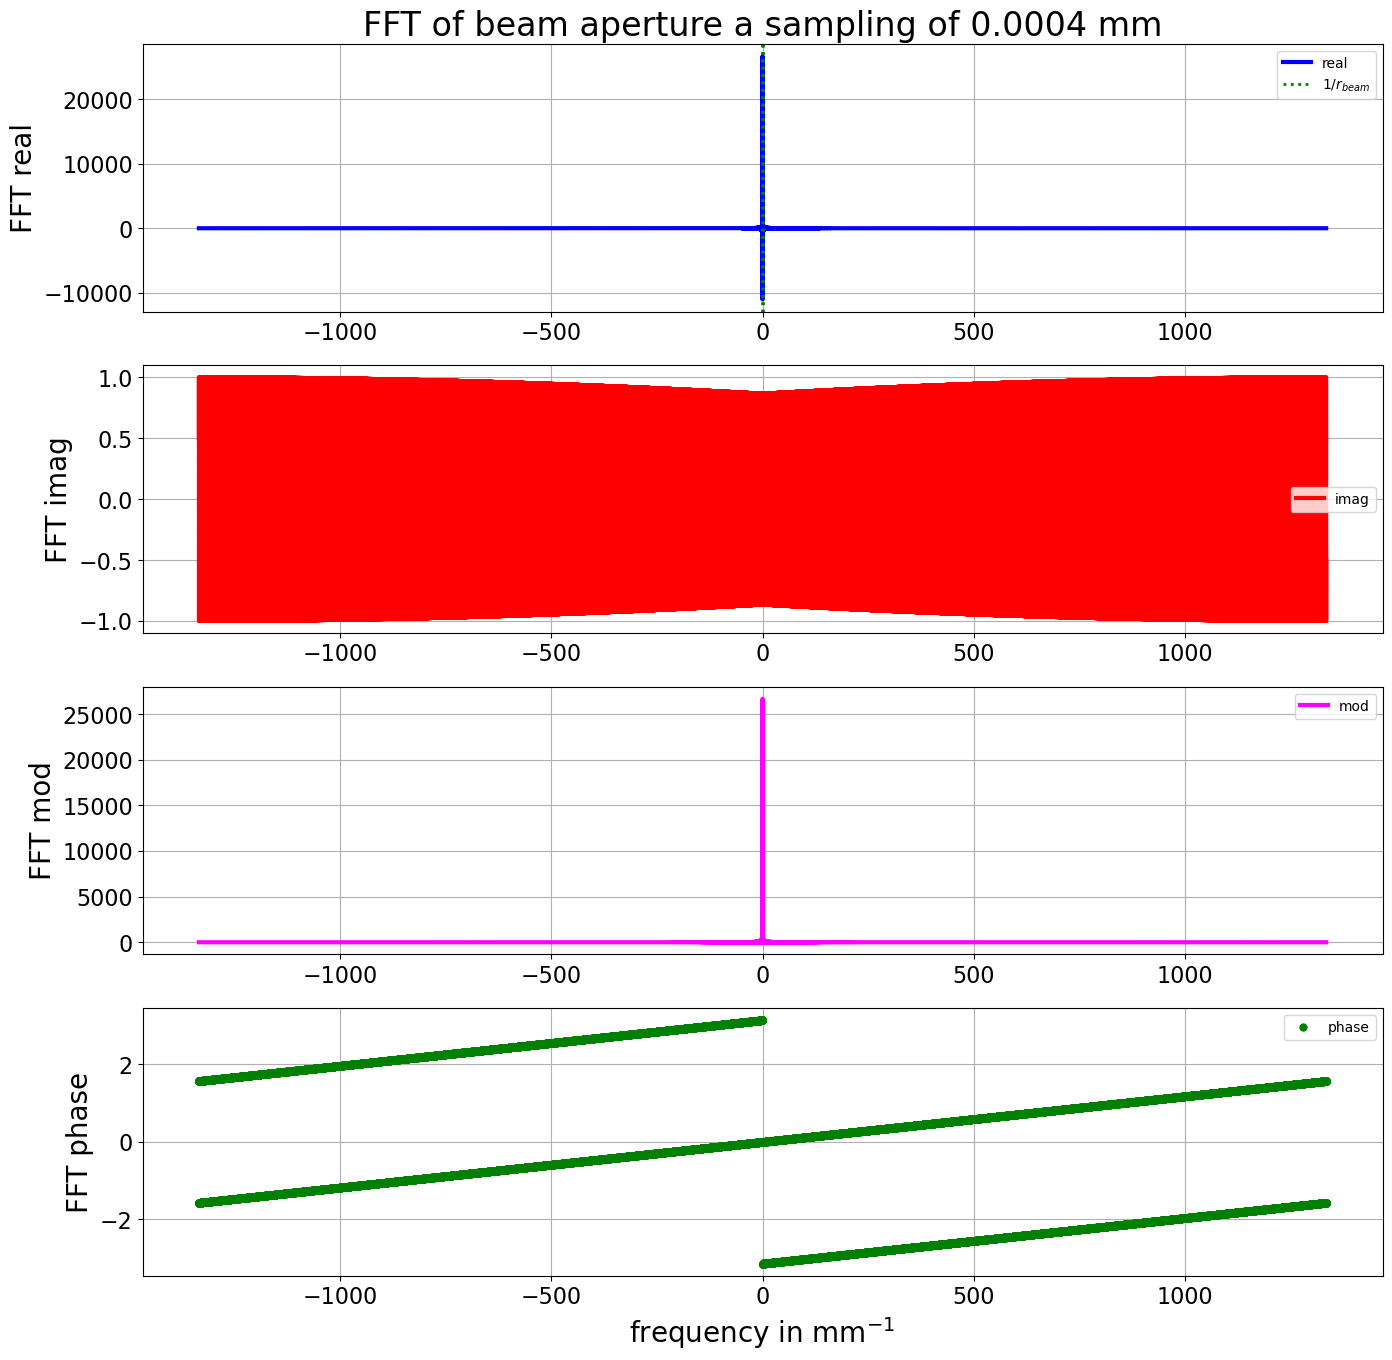

In [26]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)
ax1.plot(freqa, reala, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"FFT of beam aperture a sampling of {dxe:.4f} mm")
ax1.axvline(x=1/beam_radius_mm,c="g",ls=":",label="$1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls=":")
ax2.plot(freqa, imaga, 'r',lw=3, label = "imag")
ax2.grid()
ax3.plot(freqa, modulea, c='magenta',lw=3, label = "mod")
ax3.grid()
ax4.plot(freqa, convert_angle_to_mpi_ppi_interval(phasea),'.g',lw=3, label = "phase")
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")
ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [27]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


Text(0.5, 1.0, 'First Fourier components')

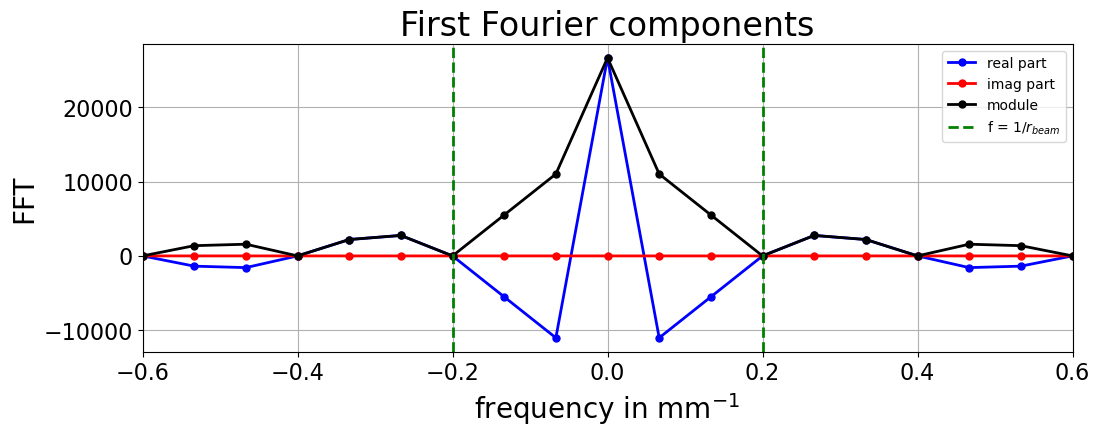

In [28]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

DF = 3*1/beam_radius_mm

ax.plot(freqa,reala,marker=".",c="b",label="real part")
ax.plot(freqa,imaga,marker=".",c="r",label="imag part")
ax.plot(freqa,modulea,marker=".",c="k",label="module")
ax.set_ylabel("FFT")
ax.set_xlim(-DF,DF)

ax.set_xlabel("frequency in mm$^{-1}$")
ax.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax.grid()
ax.legend()
ax.set_title("First Fourier components")

#### First Fourier components 

Text(0.5, 0.98, 'First coefficients of FFT for beam aperture')

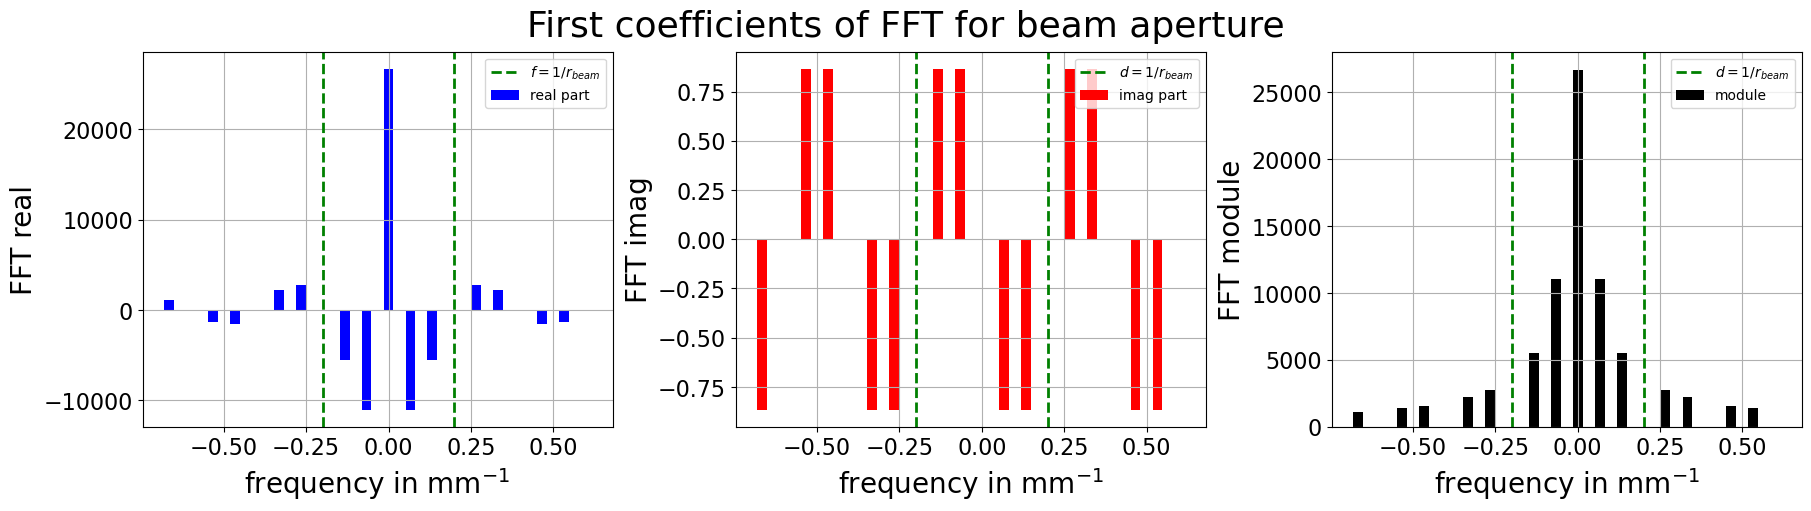

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharex=True,layout="constrained")
ax1.bar(freqa[N//2-10:N//2+10],reala[N//2-10:N//2+10],width=0.03,facecolor="b",label="real part")
ax2.bar(freqa[N//2-10:N//2+10],imaga[N//2-10:N//2+10],width=0.03,facecolor="r",label="imag part")
ax3.bar(freqa[N//2-10:N//2+10],modulea[N//2-10:N//2+10],width=0.03,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("First coefficients of FFT for beam aperture",fontsize=26)

## FFT for the beam with the optical element in place : Phase

**NOTICE :In order that the two level of $ye$ to be in opposite phase, we must have:**
- $phase = \pi$ when ye =1
- $phase = 0$ when ye =0

**MUST BE CONFIRMED**

### Transmission generated by optical element

In [30]:
#r = ap*np.exp(1j*np.pi*ye)

# NOTICE HERE I HAVE TO MULTIPLY BY 1j*pi and not 2j*pi
# ?????
#r = ap*np.exp(1j*np.pi*ye) # Old way to calculate
r = set_holo_phase_debug(xe,opticalelement_nblines_permm=Neff,xshift=0) # new way

(-0.05, 0.05)

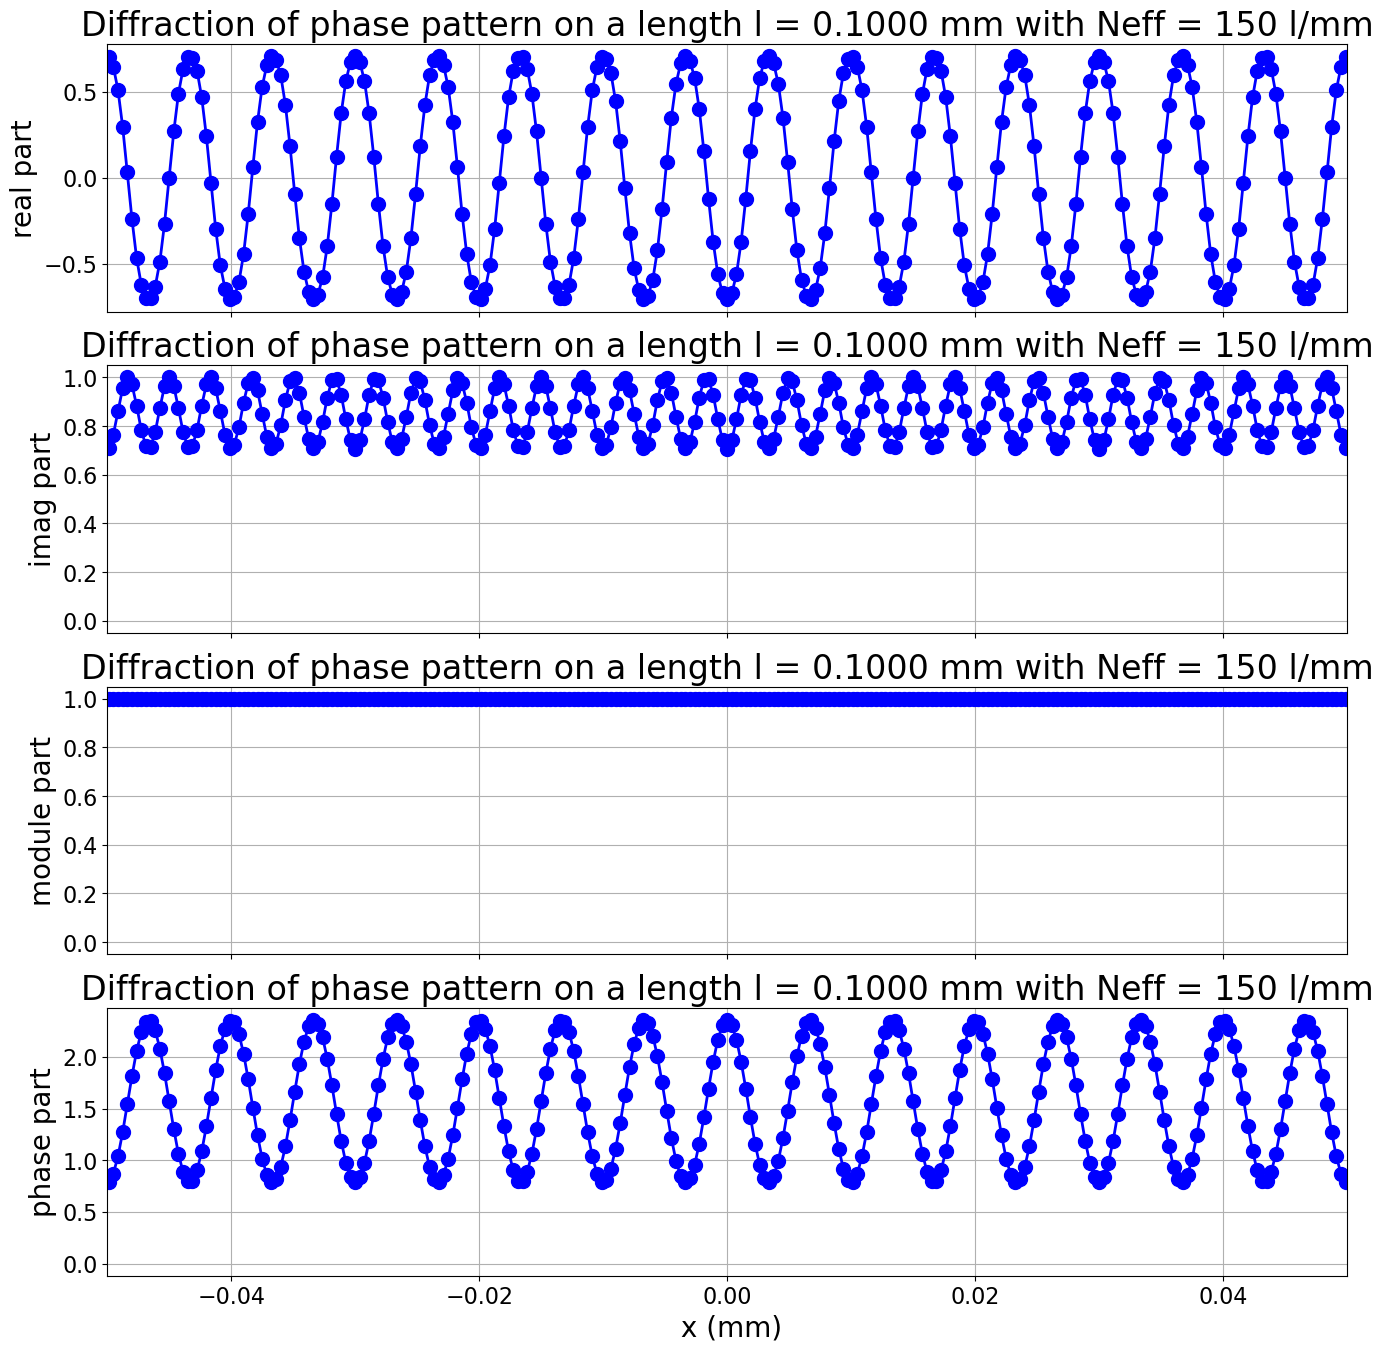

In [31]:
# check the generated pattern
fig,axs = plt.subplots(4,1,figsize=(16,16),sharex=True)
ax1,ax2,ax3,ax4 = axs.flatten()

ax1.plot(xe,r.real,'o-b',label="real part")
ax1.grid()
ax1.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax1.set_ylabel("real part")

ax2.plot(xe,r.imag,'o-b',label="imag part")
ax2.grid()
ax2.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax2.set_ylabel("imag part")

ax3.plot(xe,np.abs(r),'o-b',label="module part")
ax3.grid()
ax3.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax3.set_ylabel("module part")


ax4.plot(xe,np.angle(r),'o-b',label="phase part")
ax4.grid()
ax4.set_title(f"Diffraction of phase pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax4.set_ylabel("phase part")


ax4.set_xlabel(" x (mm)")

# choose one of the boundaries to check
ax1.set_xlim(-0.05,0.05)


#### FFT with numpy

In [32]:
sp = np.fft.fft(r)
# the frequency in units of mm^-1
# do a deep copy
freq = np.array(np.fft.fftfreq(r.shape[-1], d=dxe))
real = np.array(sp.real)
imag = np.array(sp.imag)
module = np.array(np.abs(sp))
phase = np.array(np.angle(sp))

In [33]:
freq = np.fft.fftshift(freq)
real = np.fft.fftshift(real)
imag = np.fft.fftshift(imag)
module = np.fft.fftshift(module)
phase = np.fft.fftshift(phase)
N = len(freq)

### Order 1 and order 2 components

In [34]:
# compute the spatial frequency where the order 1 and 2 are
f_order1 = Neff
f_order2 = 2*Neff

In [35]:
def plot_orders_regions(ax,df=1/beam_radius_mm):
    """
    
    """

    ax.axvline(x=df,c="pink",ls=":",label="order 0")
    ax.axvline(x=-df,c="pink",ls=":")

    if f_order1 < fmax:
        ax.axvline(x=f_order1+df,ls = ":",color="purple",label="order 1")
        ax.axvline(x=f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1+df,ls = ":",color="purple")
       
    if f_order2 < fmax:
        ax.axvline(x=f_order2+df,ls = ":",color="cyan",label="order 2")
        ax.axvline(x=f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2+df,ls = ":",color="cyan")

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

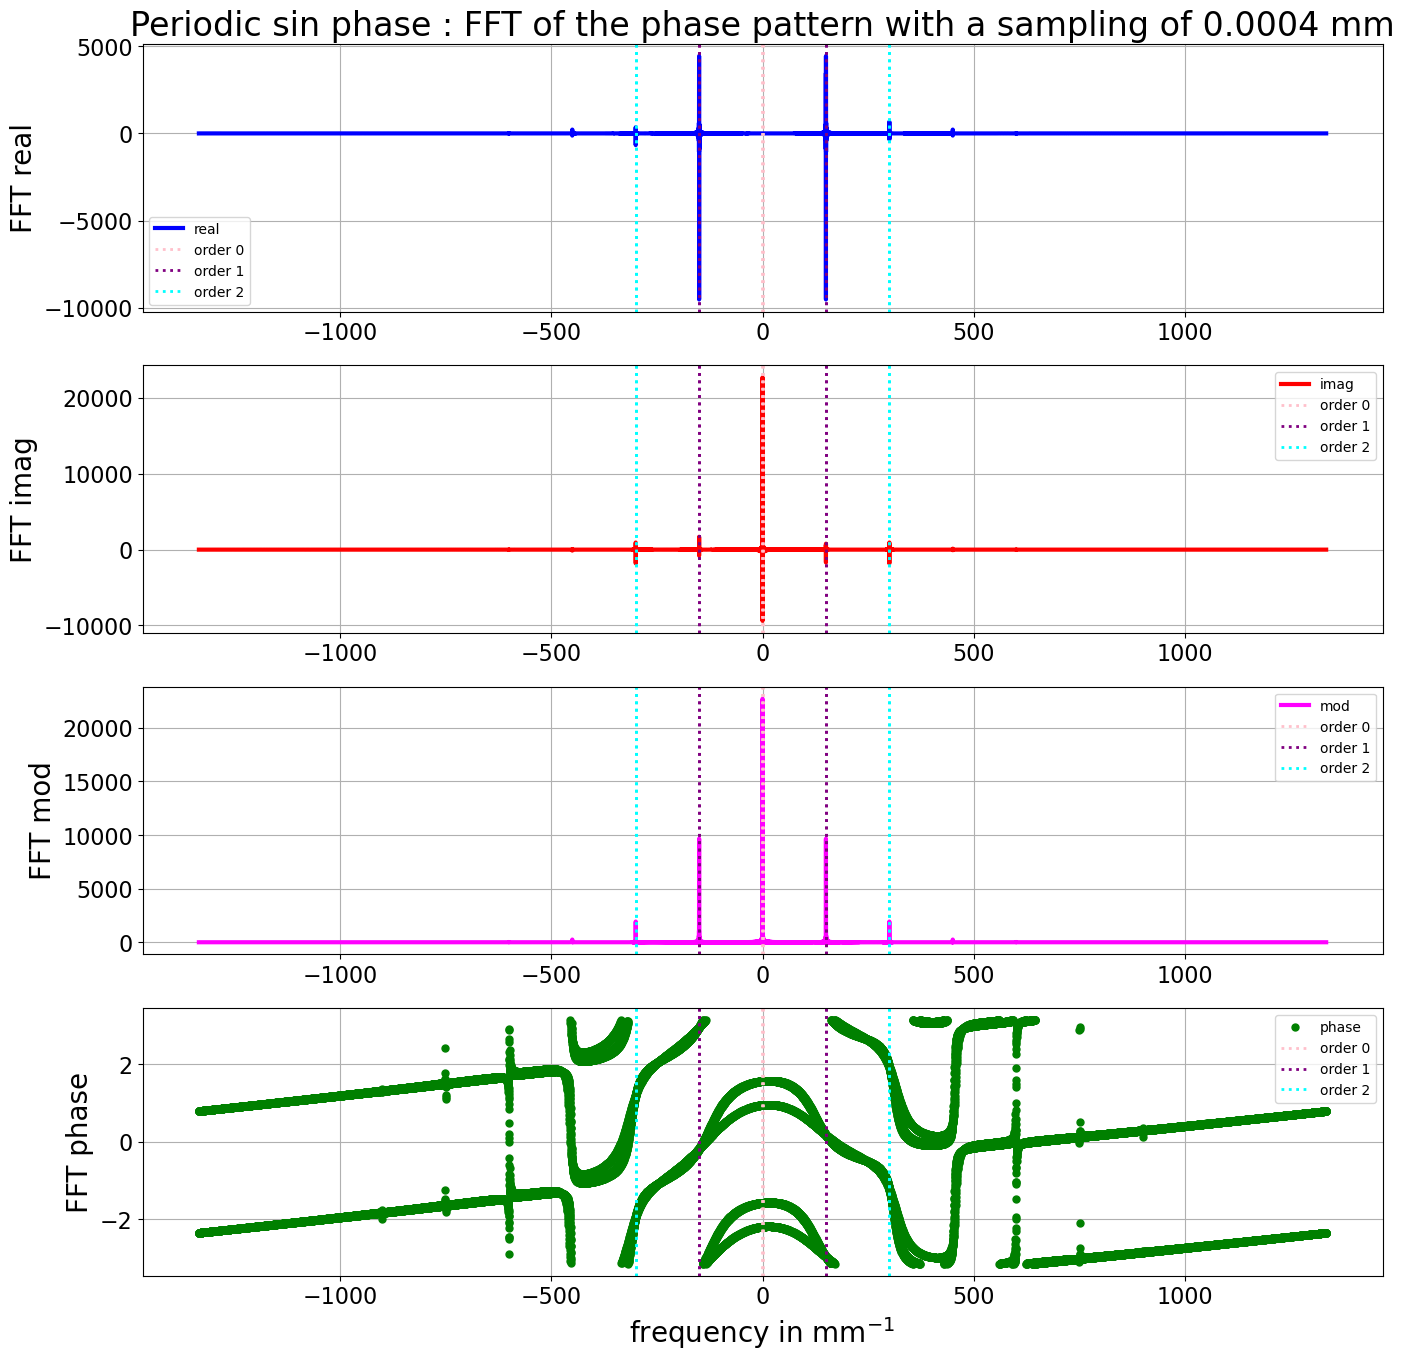

In [36]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)

ax1.plot(freq, real, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"Periodic sin phase : FFT of the phase pattern with a sampling of {dxe:.4f} mm")
plot_orders_regions(ax1)

ax2.plot(freq, imag, 'r',lw=3, label = "imag")
plot_orders_regions(ax2)
ax2.grid()

ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
plot_orders_regions(ax3)
ax3.grid()

ax4.plot(freq, convert_angle_to_mpi_ppi_interval(phase),'.g',lw=3, label = "phase")
plot_orders_regions(ax4)
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")


ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [37]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


In the following plot, we see almost zero imaginary part due to the fact the function is pair.

Text(0.5, 1.0, 'Periodic square Phase : First Fourier components (order -1)')

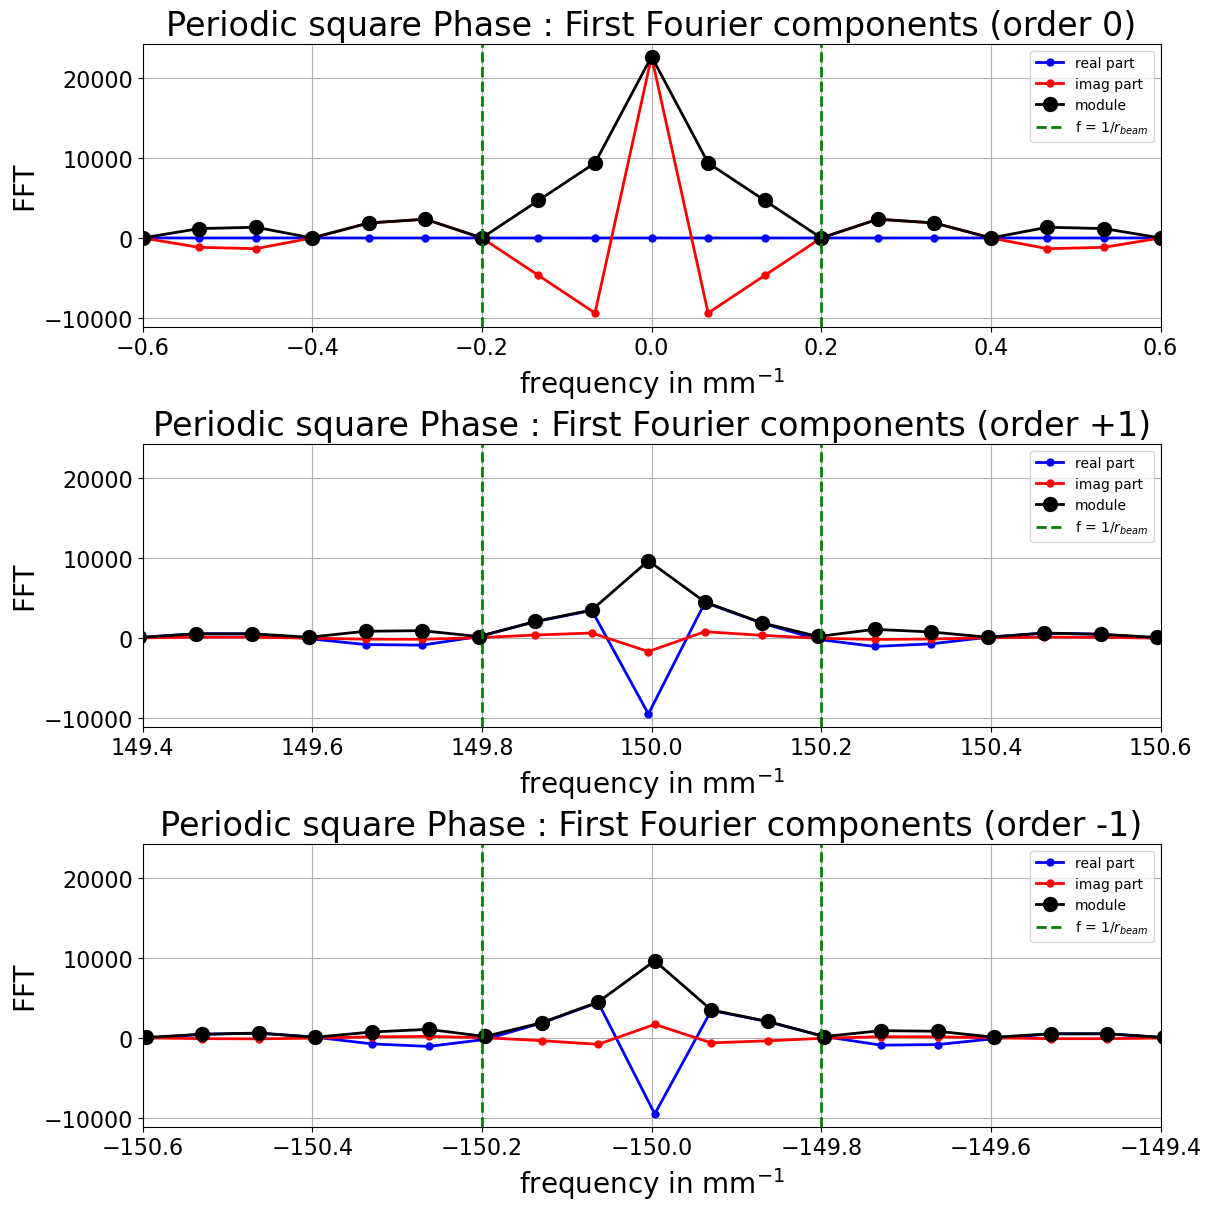

In [38]:
fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12),layout="constrained")

DF = 3*1/beam_radius_mm

ax1.plot(freq,real,marker=".",c="b",label="real part")
ax1.plot(freq,imag,marker=".",c="r",label="imag part")
ax1.plot(freq,module,marker="o",c="k",label="module")
ax1.set_ylabel("FFT")
ax1.set_xlim(-DF,DF)

ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax1.grid()
ax1.legend()
ax1.set_title("Periodic square Phase : First Fourier components (order 0)")


ax2.plot(freq,real,marker=".",c="b",label="real part")
ax2.plot(freq,imag,marker=".",c="r",label="imag part")
ax2.plot(freq,module,marker="o",c="k",label="module")
ax2.set_ylabel("FFT")
ax2.set_xlim( f_order1 -DF , f_order1+ DF)

ax2.set_xlabel("frequency in mm$^{-1}$")
ax2.axvline(x=f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax2.axvline(x=f_order1 -1/beam_radius_mm,c="g",ls="--")
ax2.grid()
ax2.legend()
ax2.set_title("Periodic square Phase : First Fourier components (order +1)")


ax3.plot(freq,real,marker=".",c="b",label="real part")
ax3.plot(freq,imag,marker=".",c="r",label="imag part")
ax3.plot(freq,module,marker="o",c="k",label="module")
ax3.set_ylabel("FFT")
ax3.set_xlim( -f_order1 -DF , -f_order1+ DF)

ax3.set_xlabel("frequency in mm$^{-1}$")
ax3.axvline(x=-f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax3.axvline(x=-f_order1 -1/beam_radius_mm,c="g",ls="--")
ax3.grid()
ax3.legend()
ax3.set_title("Periodic square Phase : First Fourier components (order -1)")



## FFT components 

In [39]:
DF = 5*1/beam_radius_mm
indexes_order_0 = np.where(np.abs(freq)<DF)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<DF)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<DF)[0]


Text(0.5, 0.98, 'Coefficients of FFT around order 0')

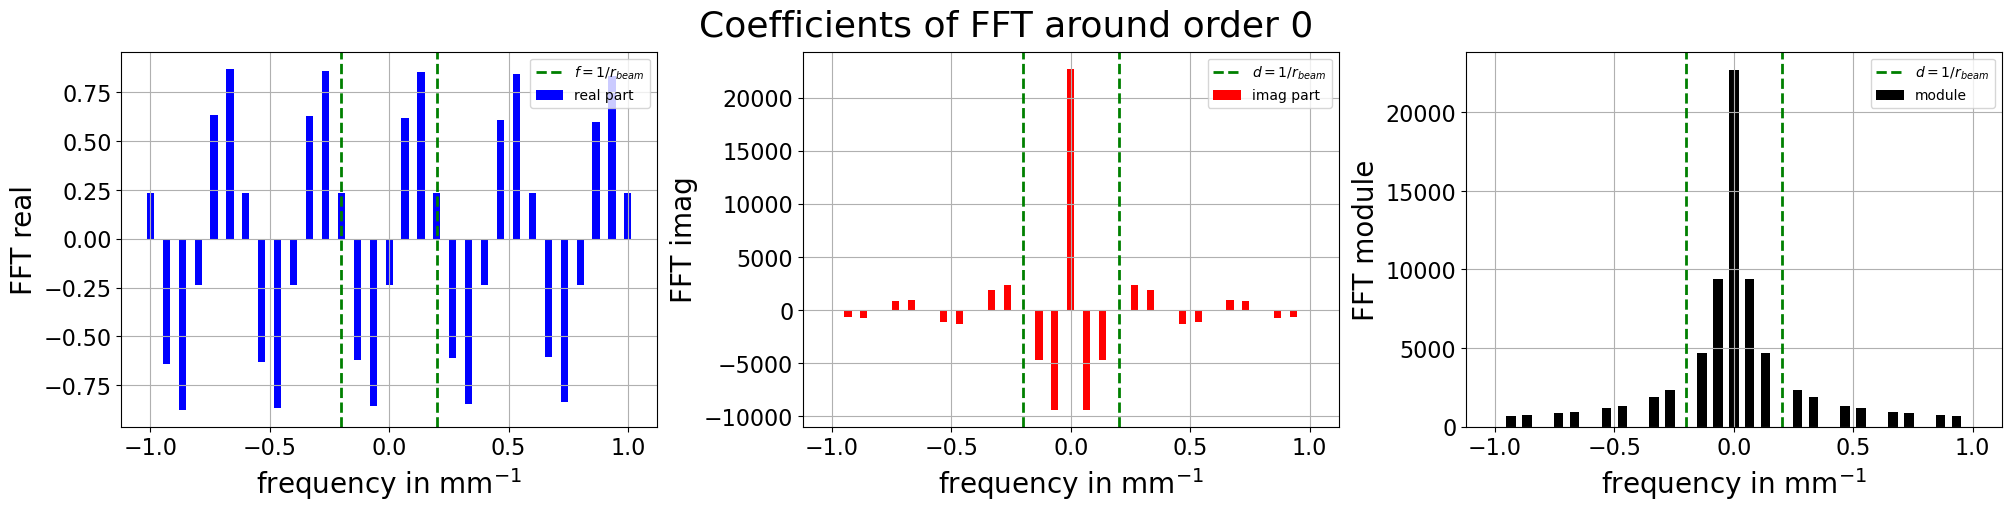

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_0],real[indexes_order_0],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_0],imag[indexes_order_0],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_0],module[indexes_order_0],width=0.04,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 0",fontsize=26)


Text(0.5, 0.98, 'Coefficients of FFT around order 1')

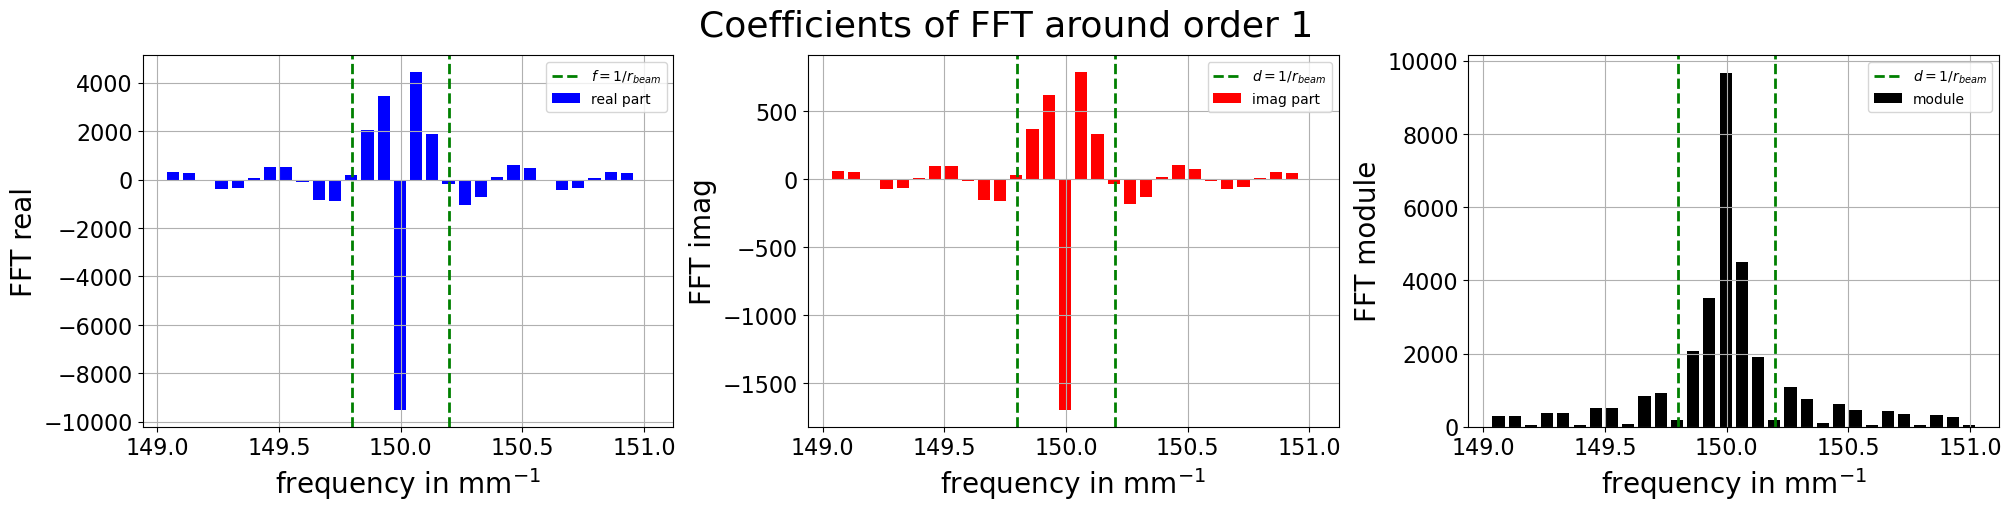

In [41]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_p1],real[indexes_order_p1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_p1],imag[indexes_order_p1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_p1],module[indexes_order_p1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 1",fontsize=26)

Text(0.5, 0.98, 'Coefficients of FFT around order -1')

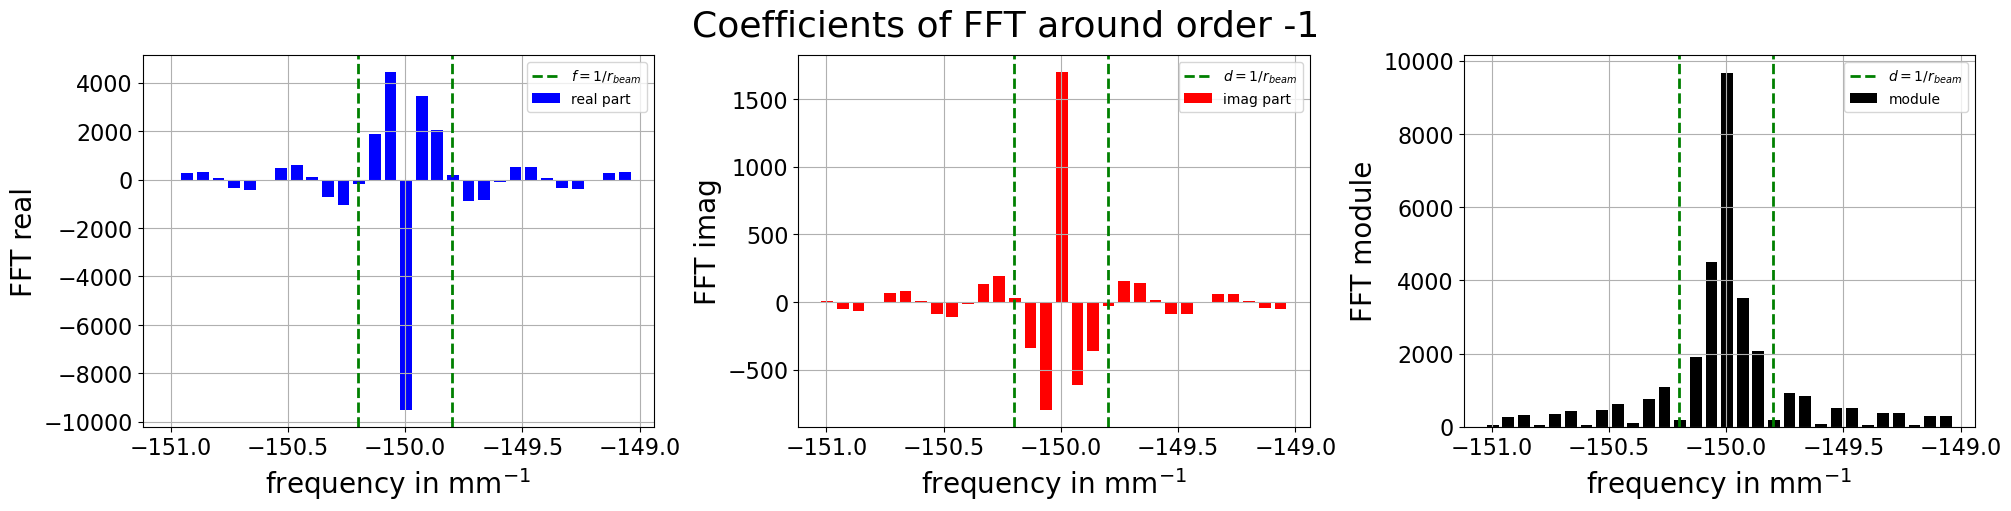

In [42]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_m1],real[indexes_order_m1],width=0.05,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_m1],imag[indexes_order_m1],width=0.05,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_m1],module[indexes_order_m1],width=0.05,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order -1",fontsize=26)

## Transmission efficiency

In [43]:
w_factor = 5.

In [44]:
indexesa_order_0 = np.where(np.abs(freqa)<w_factor /beam_radius_mm)[0]

In [45]:
indexes_order_0 = np.where(np.abs(freq)<w_factor/beam_radius_mm)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<w_factor /beam_radius_mm)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<w_factor /beam_radius_mm)[0]

In [46]:
# only beam aperture
coeffa_order_0 = modulea[indexesa_order_0]
# beam aperture + holo phase HOE
coeff_order_0 = module[indexes_order_0]
coeff_order_p1 = module[indexes_order_p1]
coeff_order_m1 = module[indexes_order_m1]

In [47]:
efficiency_orderp1 = (coeff_order_p1**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderm1 = (coeff_order_m1**2).sum()/(coeffa_order_0**2).sum()

In [48]:
print(f"Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

Transmission efficiency of order 1 : 0.1319
Transmission efficiency of order -1 : 0.1319


In [49]:
orderp1order0 = (coeff_order_p1**2).sum()/(coeff_order_0**2).sum()
orderm1order0 = (coeff_order_m1**2).sum()/(coeff_order_0**2).sum()

In [50]:
print(f"Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"Transmission radio order -1/ order 0 : {orderm1order0:.4f}")

Transmission radio order +1/ order 0 : 0.1819
Transmission radio order -1/ order 0 : 0.1819


## Compute Fourier coefficients

- CHECK Complex Fourier Series

- For $n=0$

$$
a_0 = \frac{1}{a} \int_{-a/2}^{a/2} t(x) dx
$$

- For $|n| >=1$ :
$$
a_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \cos(2\pi n \frac{x}{a}) dx
$$
$$
b_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \sin(2\pi n \frac{x}{a}) dx
$$
$$
c_n = \frac{1}{a} \int_{-a/2}^{a/2} t(x) \exp(i2\pi n \frac{x}{a}) dx
$$

### Fourier coefficients

In [51]:
xrange = np.linspace(-5*a,5*a,50000) 

In [52]:
def integrand_an_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.cos(2*np.pi*n*x/a))/a
def integrand_bn_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.sin(2*np.pi*n*x/a))/a
def integrand_cn_v0(x, n):
    return (set_beam_aperture(x,radius = beam_radius_mm)*np.exp(2j*np.pi*n*x/a))/a

Text(0.5, 0.98, 'Fourier coefficients for beam aperture')

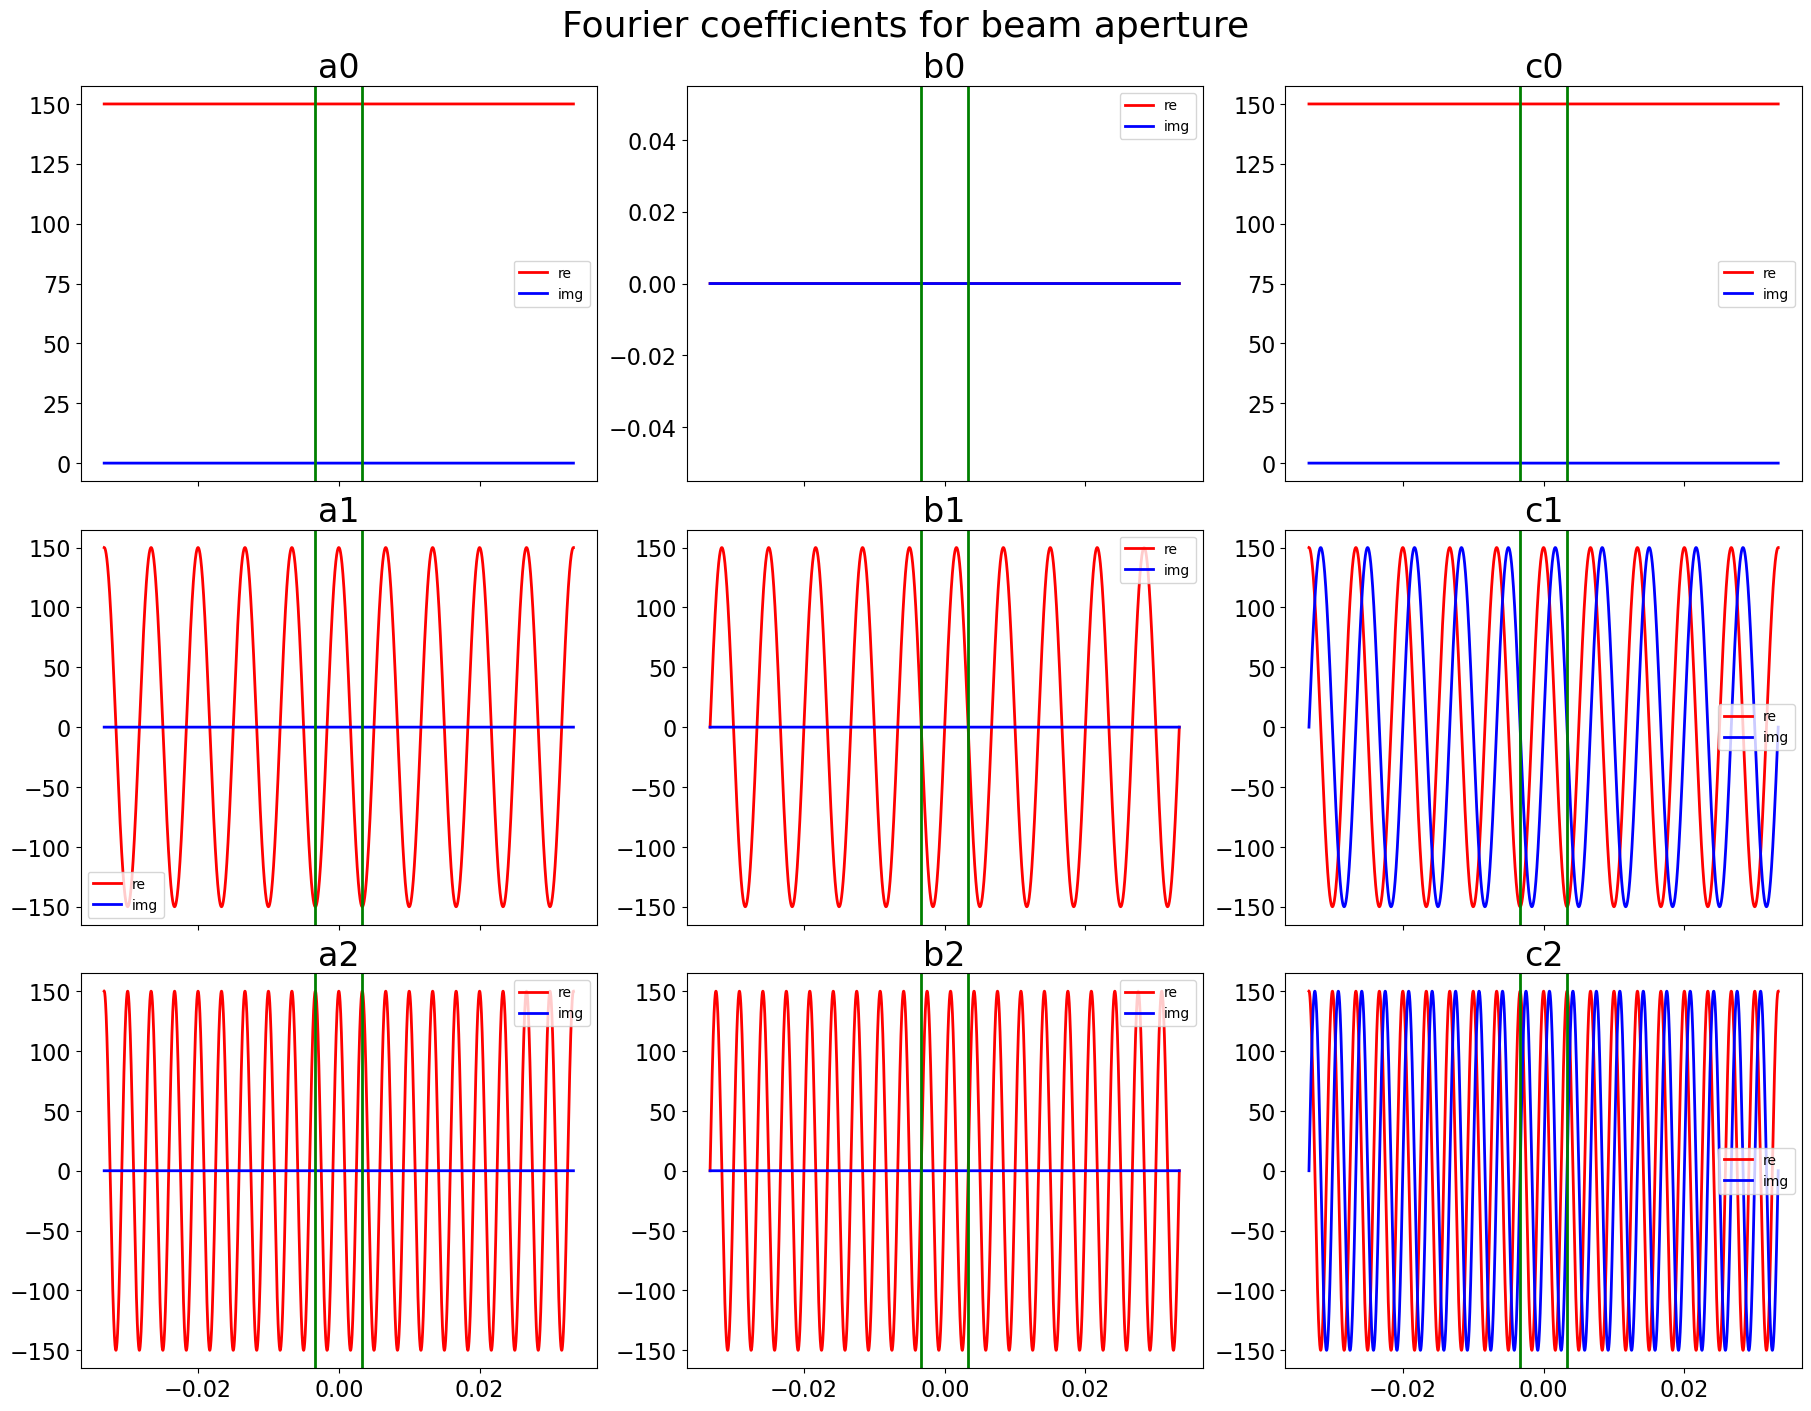

In [53]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True,layout="constrained")
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v0(xrange, 0)
y_b0 = integrand_bn_v0(xrange, 0)
y_c0 = integrand_cn_v0(xrange, 0)

y_a1 = integrand_an_v0(xrange, 1)
y_b1 = integrand_bn_v0(xrange, 1)
y_c1 = integrand_cn_v0(xrange, 1)

y_a2 = integrand_an_v0(xrange, 2)
y_b2 = integrand_bn_v0(xrange, 2)
y_c2 = integrand_cn_v0(xrange, 2)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()

plt.suptitle("Fourier coefficients for beam aperture",fontsize=26)

In [54]:
## Multiply by the phase function
def integrand_an_v2(x, n):
    return np.cos(2*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a
def integrand_bn_v2(x, n):
    return np.sin(2*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a
def integrand_cn_v2(x, n):
    return np.exp(2j*np.pi*n*x/a)*set_holo_phase_debug(x,opticalelement_nblines_permm=Neff,xshift=0)/a

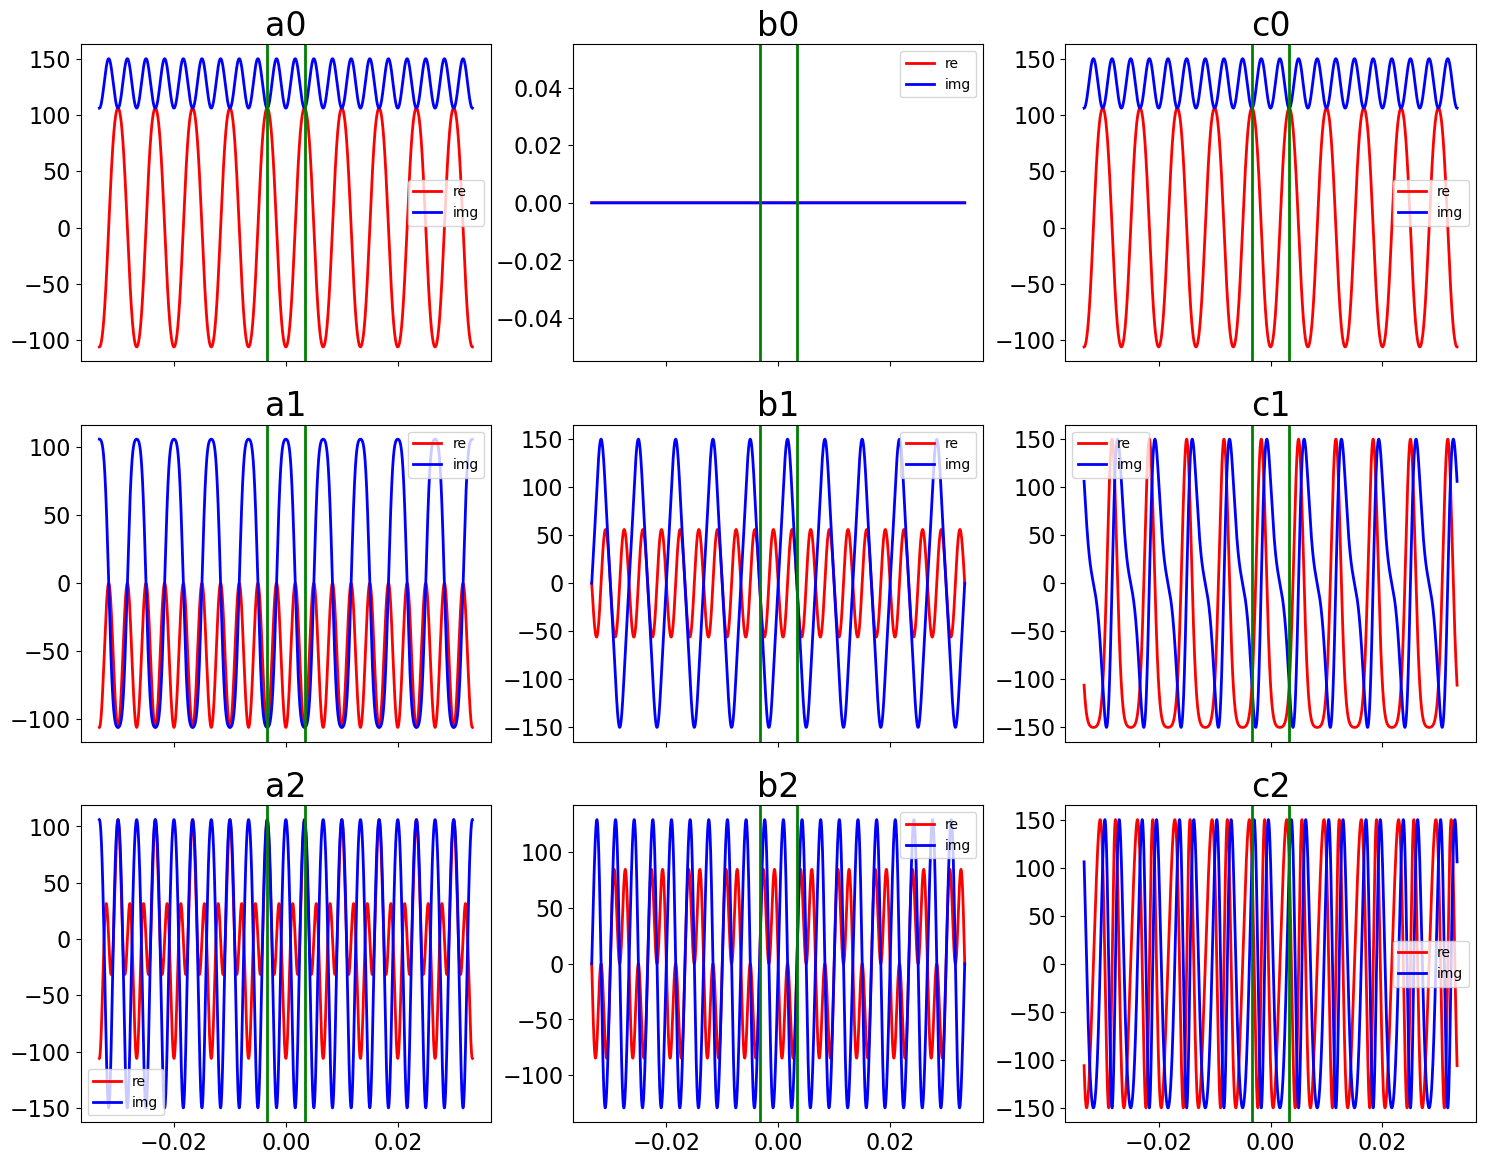

In [55]:
fig,axs = plt.subplots(3,3,figsize=(18,14),sharex=True)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.flatten()

y_a0 = integrand_an_v2(xrange, 0)
y_b0 = integrand_bn_v2(xrange, 0)
y_c0 = integrand_cn_v2(xrange, 0)

y_a1 = integrand_an_v2(xrange, 1)
y_b1 = integrand_bn_v2(xrange, 1)
y_c1 = integrand_cn_v2(xrange, 1)

y_a2 = integrand_an_v2(xrange, 2)
y_b2 = integrand_bn_v2(xrange, 2)
y_c2 = integrand_cn_v2(xrange, 2)

ax1.plot(xrange,y_a0.real,'r-',label="re")
ax1.plot(xrange,y_a0.imag,'b-',label="img")
ax1.set_title("a0")
ax1.axvline(-a/2,color="g")
ax1.axvline(a/2,color="g")
ax1.legend()

ax2.plot(xrange,y_b0.real,'r-',label="re")
ax2.plot(xrange,y_b0.imag,'b-',label="img")
ax2.set_title("b0")
ax2.axvline(-a/2,color="g")
ax2.axvline(a/2,color="g")
ax2.legend()

ax3.plot(xrange,y_c0.real,'r-',label="re")
ax3.plot(xrange,y_c0.imag,'b-',label="img")
ax3.set_title("c0")
ax3.axvline(-a/2,color="g")
ax3.axvline(a/2,color="g")
ax3.legend()

ax4.plot(xrange,y_a1.real,'r-',label="re")
ax4.plot(xrange,y_a1.imag,'b-',label="img")
ax4.set_title("a1")
ax4.axvline(-a/2,color="g")
ax4.axvline(a/2,color="g")
ax4.legend()

ax5.plot(xrange,y_b1.real,'r-',label="re")
ax5.plot(xrange,y_b1.imag,'b-',label="img")
ax5.set_title("b1")
ax5.axvline(-a/2,color="g")
ax5.axvline(a/2,color="g")
ax5.legend()

ax6.plot(xrange,y_c1.real,'r-',label="re")
ax6.plot(xrange,y_c1.imag,'b-',label="img")
ax6.set_title("c1")
ax6.axvline(-a/2,color="g")
ax6.axvline(a/2,color="g")
ax6.legend()


ax7.plot(xrange,y_a2.real,'r-',label="re")
ax7.plot(xrange,y_a2.imag,'b-',label="img")
ax7.set_title("a2")
ax7.axvline(-a/2,color="g")
ax7.axvline(a/2,color="g")
ax7.legend()


ax8.plot(xrange,y_b2.real,'r-',label="re")
ax8.plot(xrange,y_b2.imag,'b-',label="img")
ax8.set_title("b2")
ax8.axvline(-a/2,color="g")
ax8.axvline(a/2,color="g")
ax8.legend()


ax9.plot(xrange,y_c2.real,'r-',label="re")
ax9.plot(xrange,y_c2.imag,'b-',label="img")
ax9.set_title("c2")
ax9.axvline(-a/2,color="g")
ax9.axvline(a/2,color="g")
ax9.legend()

### Compute Fourier coefficients

#### Order zero coefficients

##### Order 0 for beam aperture only

In [56]:
a0_v0 = quad(integrand_an_v0, -a/2, a/2, args=(0,))
b0_v0 = quad(integrand_bn_v0, -a/2, a/2, args=(0,))
c0_v0 = quad(integrand_cn_v0, -a/2, a/2, args=(0,))
# transform tuples from quad function in  complex numbers
a0_v1 = a0_v0[0] + 1j* a0_v0[1]
b0_v1 = b0_v0[0] + 1j* b0_v0[1]
c0_v1 = c0_v0[0] + 1j* c0_v0[1]
print(f"v1 : (a0,b0,c0) = ({a0_v1:.4f},{b0_v1:.4f}, {c0_v1:.4f})")

v1 : (a0,b0,c0) = (1.0000+0.0000j,0.0000+0.0000j, 1.0000+0.0000j)


/Users/dagoret/anaconda3/envs/poppy_py312/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


- **Notice : Presence of order 0 in aperture beam**

##### Order 0 from HOE  in beam

In [57]:
a0_v2 = quad(integrand_an_v2, -a/2, a/2, args=(0,))
b0_v2 = quad(integrand_bn_v2, -a/2, a/2, args=(0,))
c0_v2 = quad(integrand_cn_v2, -a/2, a/2, args=(0,))
# transform tuples from quad function in  complex numbers
a0_v3 = a0_v2[0] + 1j* a0_v2[1]
b0_v3 = b0_v2[0] + 1j* b0_v2[1]
c0_v3 = c0_v2[0] + 1j* c0_v2[1]
print(f"v3 : (a0,b0,c0) = ({a0_v3:.4f},{b0_v3:.4f}, {c0_v3:.4f})")

v3 : (a0,b0,c0) = (0.0000+0.0000j,0.0000+0.0000j, 0.0000+0.0000j)


- **Notice : No order 0 in HOE**

#### Order 1 coefficients

##### Order 1 from  beam aperture

In [58]:
a1_v0 = quad(integrand_an_v0, -a/2, a/2, args=(1,))
b1_v0 = quad(integrand_bn_v0, -a/2, a/2, args=(1,))
c1_v0 = quad(integrand_cn_v0, -a/2, a/2, args=(1,))

# transform tuples in  complex numbers
a1_v1 = a1_v0[0] + 1j* a1_v0[1]
b1_v1 = b1_v0[0] + 1j* b1_v0[1]
c1_v1 = c1_v0[0] + 1j* c1_v0[1]
print(f"v1 : (a1,b1,c1) = ({a1_v1:.4f},{b1_v1:.4f},{c1_v1:.4f})")

v1 : (a1,b1,c1) = (0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j)


- **Notice : No order 1 in aperture beam**

##### Order 1 from HOE  in beam

In [59]:
a1_v2 = quad(integrand_an_v2, -a/2, a/2, args=(1,))
b1_v2 = quad(integrand_bn_v2, -a/2, a/2, args=(1,))
c1_v2 = quad(integrand_cn_v2, -a/2, a/2, args=(1,))

# transform tuples in  complex numbers
a1_v3 = a1_v2[0] + 1j* a1_v2[1]
b1_v3 = b1_v2[0] + 1j* b1_v2[1]
c1_v3 = c1_v2[0] + 1j* c1_v2[1]
print(f"v3 : (a1,b1,c1) = ({a1_v3:.4f},{b1_v3:.4f},{c1_v3:.4f})")

v3 : (a1,b1,c1) = (-0.3632+0.0000j,0.0000+0.0000j,-0.3632+0.0000j)


- **Notice : Order 1 in HOE**

#### Other Orders n>=2 coefficients

In [60]:
sum_supp2_ab = 0
sum_supp2_c = 0

for n in range(2,10):
    an = quad(integrand_an_v0, -a/2, a/2, args=(n,))
    bn = quad(integrand_bn_v0, -a/2, a/2, args=(n,))
    cn = quad(integrand_cn_v0, -a/2, a/2, args=(n,))
    
    # convert tuple into complex number
    an_v0 = an[0]+ 1j*an[1]
    bn_v0 = bn[0]+ 1j*bn[1]
    cn_v0 = cn[0]+ 1j*cn[1]

    sum_supp2_ab += np.absolute(an_v0)**2 + np.absolute(bn_v0)**2 
    sum_supp2_c += np.absolute(cn_v0)**2 
print(sum_supp2_ab,sum_supp2_c)

1.616198196991712e-18 1.6161981935311786e-18


- **Notice : Order 1 in HOE**

In [61]:
sum_supp2_v2_ab = 0
sum_supp2_v2_c = 0
for n in range(2,10):
    an = quad(integrand_an_v2, -a/2, a/2, args=(n,))
    bn = quad(integrand_bn_v2, -a/2, a/2, args=(n,))
    cn = quad(integrand_cn_v2, -a/2, a/2, args=(n,))
    
    # convert tuple into complex number
    an_v2 = an[0]+ 1j*an[1]
    bn_v2 = bn[0]+ 1j*bn[1]
    cn_v2 = cn[0]+ 1j*cn[1]
    
    sum_supp2_v2_ab += np.absolute(an_v2)**2 + np.absolute(bn_v2)**2 
    sum_supp2_v2_c += np.absolute(cn_v2)**2 
print(sum_supp2_v2_ab,sum_supp2_v2_c)

9.429013487107169e-05 9.429013487107189e-05


### Transmission efficiency and order ratio

#### Efficiency

In [62]:
# ratio when the HOE in place wrt with beam aperture
efficiency_order0 = np.absolute(c0_v3)**2/np.absolute(c0_v1)**2 
efficiency_orderp1 = np.absolute(c1_v3)**2/np.absolute(c0_v1)**2 
efficiency_orderm1 = np.absolute(c1_v3)**2/np.absolute(c0_v1)**2 

In [63]:
print(f"Fourier Coeff : Transmission efficiency of order 0 : {efficiency_order0:.4f}")
print(f"Fourier Coeff : Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Fourier Coeff : Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

Fourier Coeff : Transmission efficiency of order 0 : 0.0000
Fourier Coeff : Transmission efficiency of order 1 : 0.1319
Fourier Coeff : Transmission efficiency of order -1 : 0.1319


In [64]:
efficiency_order0_v2 = np.absolute(c0_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)
efficiency_orderp1_v2 = np.absolute(c1_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)
efficiency_orderm1_v2 =  np.absolute(c1_v3)**2/(np.absolute(c0_v3)**2 + 2*(np.absolute(c1_v3))**2 + 2*sum_supp2_v2_c)

In [65]:
print(f"Fourier Coeff : v2 : Transmission efficiency of order 0 : {efficiency_order0_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission efficiency of order 1 : {efficiency_orderp1_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission efficiency of order -1 : {efficiency_orderm1_v2:.4f}")

Fourier Coeff : v2 : Transmission efficiency of order 0 : 0.0000
Fourier Coeff : v2 : Transmission efficiency of order 1 : 0.4996
Fourier Coeff : v2 : Transmission efficiency of order -1 : 0.4996


#### Order ratio

In [66]:
orderp1order0_v2 = np.absolute(c1_v3)**2/np.absolute(c0_v3)**2
orderm1order0_v2 = np.absolute(c1_v3)**2/np.absolute(c0_v3)**2

In [67]:
print(f"Fourier Coeff : v2 : Transmission radio order +1/ order 0 : {orderp1order0_v2:.4f}")
print(f"Fourier Coeff : v2 : Transmission radio order -1/ order 0 : {orderm1order0_v2:.4f}")

Fourier Coeff : v2 : Transmission radio order +1/ order 0 : 4964952840887558672385835008.0000
Fourier Coeff : v2 : Transmission radio order -1/ order 0 : 4964952840887558672385835008.0000
